In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 11:26:27.364481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 11:26:28.968884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 11000
end_idx = 11500
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(500, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(500, 96, 7)
(336000,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(500, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(500, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 11:26:38.592158: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:85:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 11:26:41.952127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step
CPU time: 7819.162102938164 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

16/16 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.6955426  0.95604586 0.51626999 ... 0.00112058 0.26769675 0.27280244]
Fitness value of the best solution = 0.0006008264303306468


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

16/16 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


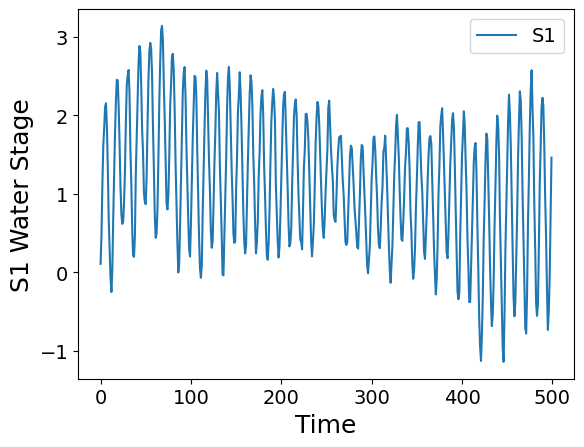

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low13.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.695543,0.956046,0.516270,0.520998,0.699042,0.989891,0.127647,0.444973,0.126184,0.104244,...,0.159808,0.056155,0.999065,0.079471,0.325291,0.950250,0.307315,0.249379,0.987127,0.469833
1,0.916846,0.365923,0.196649,0.473589,0.195124,0.393075,0.121647,0.410725,0.283407,0.459767,...,0.541708,0.294746,0.511764,0.198188,0.699002,0.594324,0.714989,0.002268,0.724683,0.066560
2,0.387282,0.835333,0.903816,0.090312,0.672022,0.100384,0.511098,0.459176,0.288025,0.378424,...,0.112914,0.385917,0.139981,0.459018,0.652918,0.081181,0.960277,0.925942,0.651486,0.603610
3,0.000124,0.750829,0.469202,0.697152,0.845263,0.105519,0.484052,0.841144,0.927468,0.673615,...,0.508445,0.874560,0.824806,0.064058,0.288048,0.824735,0.830705,0.478276,0.870760,0.508494
4,0.219506,0.739037,0.746867,0.986279,0.137331,0.542349,0.121632,0.624962,0.372305,0.357986,...,0.652710,0.069588,0.908247,0.241213,0.655303,0.383330,0.691218,0.014434,0.134090,0.689866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.314225,0.159950,0.665395,0.860447,0.925342,0.826174,0.381220,0.375379,0.514907,0.301222,...,0.055842,0.185956,0.981312,0.965050,0.083657,0.989947,0.075516,0.395357,0.401976,0.623535
496,0.476560,0.987566,0.247029,0.920073,0.375911,0.013689,0.692278,0.069947,0.397664,0.546151,...,0.968373,0.812460,0.042700,0.055504,0.338682,0.935109,0.472873,0.175764,0.858323,0.485148
497,0.993070,0.295219,0.703157,0.397609,0.418410,0.357776,0.868579,0.444225,0.101543,0.510365,...,0.037411,0.040995,0.195700,0.893531,0.647679,0.588932,0.992510,0.087838,0.224606,0.139181
498,0.381696,0.376550,0.696840,0.554954,0.503489,0.439539,0.912937,0.699094,0.765130,0.959032,...,0.212147,0.955844,0.896734,0.712206,0.556391,0.127696,0.996419,0.728708,0.927070,0.488029


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low13.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.105479,-0.124220,0.126366,0.041503,0.580638,0.606886,0.523583,0.563407,0.967105,1.042210,...,1.642154,1.772933,1.227847,1.113957,1.278320,1.401616,0.968247,0.728917,1.072460,1.146354
1,0.470920,0.265342,0.465653,0.486335,1.086923,1.054959,1.069786,1.119533,1.517030,1.361404,...,1.336765,1.352283,0.910009,1.005972,1.078675,1.026129,0.725191,0.609229,0.853459,0.799143
2,1.118092,0.850112,1.098963,1.102345,1.533592,1.409711,1.466142,1.514913,1.964469,1.862957,...,0.912372,0.896459,0.723433,0.901642,0.855738,0.855127,0.722650,0.769428,0.815140,0.851730
3,1.611881,1.587521,1.625583,1.597217,1.936554,1.770440,1.849456,1.888816,2.228136,2.040776,...,0.787836,0.748924,0.767622,0.883986,0.903859,0.876361,0.956465,0.801924,1.114604,1.072101
4,1.836963,2.009555,1.784582,1.810355,2.231434,2.316527,2.114746,2.197223,2.202409,2.309960,...,0.667997,0.588322,0.861447,1.118476,0.963046,0.984331,1.272063,1.234091,1.328840,1.376348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.736453,-0.717200,-0.692926,-0.730686,-0.696873,-0.789073,-0.649332,-0.683332,-0.113255,0.132085,...,1.394738,1.483369,0.602026,0.810368,0.856421,0.790239,0.020287,0.510836,0.298757,0.256867
496,-0.499124,-0.361701,-0.354508,-0.476954,-0.047397,-0.186962,-0.006623,-0.094445,0.789403,0.826723,...,0.819749,0.873167,0.223670,0.657406,0.484829,0.430197,-0.458981,-0.248992,-0.137815,-0.294121
497,-0.065897,-0.044775,0.061959,0.051753,0.703208,0.585543,0.681691,0.765818,1.434561,1.324407,...,0.155988,0.241011,-0.382049,-0.110735,-0.151293,-0.266017,-0.636468,-0.275733,-0.467332,-0.550654
498,0.726380,0.372345,0.679264,0.742605,1.361625,1.232615,1.293996,1.392792,2.039647,1.981977,...,-0.386991,-0.448700,-0.658551,-0.615012,-0.446575,-0.579289,-0.603452,-0.527909,-0.479270,-0.536478


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 3115, areas: 1013.2087027835441


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

16/16 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 4963, areas: 2153.3274747209507
